In [1]:
import torch
import numpy as np
import mediapy
import pickle
from scipy.io import savemat
import argparse
from tqdm import tqdm
from aux.tracking_viz import generate_frame_image_cv
from src.new_queries import add_new_tracks

import matplotlib.pyplot as plt
from src.factorization import marques_factorization
import rerun as rr
from src.mat_compl import alternating_matrix_completion

%load_ext autoreload
%autoreload 2

# add tapnext to pythonpath
import sys
sys.path.append("/home/manuelf/tapnet")
from tapnet.tapnext.tapnext_torch import TAPNext # type: ignore
from tapnet.tapnext.tapnext_torch_utils import restore_model_from_jax_checkpoint # type: ignore

def init_tapnext(device):

  tapnext = TAPNext(image_size=(256, 256)).to(device)

  #set model to eval, not backprop
  tapnext.eval()
  for p in tapnext.parameters():
    p.requires_grad = False

  tapnext = restore_model_from_jax_checkpoint(tapnext, "/home/manuelf/tapnet/tapnet/tapnext/tapnet/checkpoints/bootstapnext_ckpt.npz")

  return tapnext

/home/manuelf/miniconda3/envs/trackers/lib/python3.11/site-packages/torch/_export/utils.py:415: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _register_pytree_node(


In [2]:
import cv2 as cv
from aux.read_video import read_video_torch

model_video_size = (256, 256)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cuda:0"

video_resized, video = read_video_torch("../mast3r/images_in/bordalo.mp4",model_video_size, device)

tapnext = init_tapnext(device)

torch.cuda.empty_cache()

video_resized.shape

torch.Size([223, 256, 256, 3])

In [4]:

# Design the query points array in the original video size
step = 40
ys, xs = np.meshgrid(np.linspace(8, video[0].shape[0]-step, step), np.linspace(8, video[0].shape[1]-step, step))
query_points_initial = torch.tensor(
    np.stack(
    [np.zeros(len(xs.flatten())), xs.flatten(), ys.flatten()], axis=1
)[None],dtype=torch.float32).to(device)

im = cv.resize( cv.cvtColor(np.array((video[0]+1)/2*255).copy().astype(np.uint8), cv.COLOR_RGB2BGR), 
               tuple(np.flip(np.array(video[0].shape[0:2]))*5) ) # Copy the first frame for visualization

#write text with opencv
for i in range(query_points_initial.shape[1]):
    im = cv.putText(img=im, text=str(i), org=(int(query_points_initial[0, i, 1].item()*5), int(query_points_initial[0, i, 2].item()*5)),
                     fontFace=cv.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
    
cv.imwrite("query_points_initial.png", im)

#resize the querys points to the model size
query_points_initial[0, :, 1:3] /= torch.tensor([video[0].shape[1] / model_video_size[0], video[0].shape[0] / model_video_size[1]]).to(device)

#creata tensors for the video information
video_tensor_original = torch.cat([torch.tensor(frame).unsqueeze(0) for frame in video]).unsqueeze(0) # 1, time, H, W, 3
video_tensor_resized = torch.cat([torch.tensor(frame).unsqueeze(0) for frame in video_resized]).unsqueeze(0).to(device) # 1, time, H, W, 3

/tmp/ipykernel_58773/2490345035.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  im = cv.resize( cv.cvtColor(np.array((video[0]+1)/2*255).copy().astype(np.uint8), cv.COLOR_RGB2BGR),
/tmp/ipykernel_58773/2490345035.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  video_tensor_original = torch.cat([torch.tensor(frame).unsqueeze(0) for frame in video]).unsqueeze(0) # 1, time, H, W, 3
/tmp/ipykernel_58773/2490345035.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), r

In [ ]:

# INFERENCE
next_track_id = 0  # unique ID for every track
track_histories = {}  # track_id -> list of (frame_index, (x, y)) or None
active_tracks = {}  # current_idx -> track_id (used during current step)

with torch.no_grad():
  with torch.amp.autocast('cuda', dtype=torch.float32, enabled=True):
    
    tracks, tracks_logits, visible_logits, tracking_state = tapnext(video=video_tensor_resized[:, :1], query_points=query_points_initial)

    num_feats = tracks.shape[2]
    for i in range(num_feats):
        track_id = next_track_id
        next_track_id += 1
        active_tracks[i] = track_id
        track_histories[track_id] = [(0, tracks[0, 0, i, :2].cpu())]  # frame 0 position

    for k in tqdm(range(1, video_tensor_resized.shape[1])):

        tracks_step, tracks_logits_step, visible_logits_step, tracking_state = tapnext(
            video=video_tensor_resized[:, k:k + 1],
            state=tracking_state)
        
        # trakcs_step sai sempre bem 

        visible = (visible_logits_step.squeeze() > 0).cpu()
        for i, track_tensor in enumerate(tracks_step[0, 0]):
            track_id = active_tracks.get(i, None)
            if track_id is not None:
                if visible[i]:
                    track_histories[track_id].append((k, track_tensor[:2].cpu()))
                else:
                    track_histories[track_id].append((k, None))  # Not visible

        # New feature detection
        new_tracks = add_new_tracks(tracks_step, query_points_initial)
        
        #if 0:
        if new_tracks is not None and new_tracks.shape[1] > 120:
            print(f"Adding new tracks: {new_tracks.shape[1]}")

            new_tracks[0, :, 0] = 0  # set time to 0 for tapnext reinit

            # retain visible active tracks from previous step
            retained_indices = [i for i, v in enumerate(visible) if v]
            retained_ids = [active_tracks[i] for i in retained_indices]

            retained_tracks = tracks_step[0, 0, retained_indices].unsqueeze(0)
            zero_time = torch.zeros((1, len(retained_indices), 1)).to(retained_tracks.device)
            retained_tracks = torch.cat([zero_time, retained_tracks], dim=2)

            concat_tracks = torch.cat([retained_tracks, new_tracks.to(device)], dim=1)

            tracks_step, tracks_logits_step, visible_logits_step, tracking_state = tapnext(
                video=video_tensor_resized[:, k].unsqueeze(0),
                query_points=concat_tracks)

            # update active_tracks dict
            active_tracks = {}
            for i, id in enumerate(retained_ids):
                active_tracks[i] = id  # preserve old IDs

            new_start = len(retained_ids)
            visible = (visible_logits_step.squeeze() > 0).cpu()
            for i in range(new_tracks.shape[1]):
                track_id = next_track_id
                next_track_id += 1
                active_tracks[new_start + i] = track_id
                if visible[new_start + i]:
                    # Only add if the new track is visible
                    track_histories[track_id] = [(k, tracks_step[0, 0, new_start + i, :2].cpu())]
                else:
                    track_histories[track_id] = [(k, None)]

In [136]:
# save track_histories as pkl so i can load it later
with open(f"track_histories.pkl", "wb") as f:
    pickle.dump(track_histories, f)

In [5]:
#load track_histories from pkl
with open("track_histories.pkl", "rb") as f:
    track_histories = pickle.load(f)

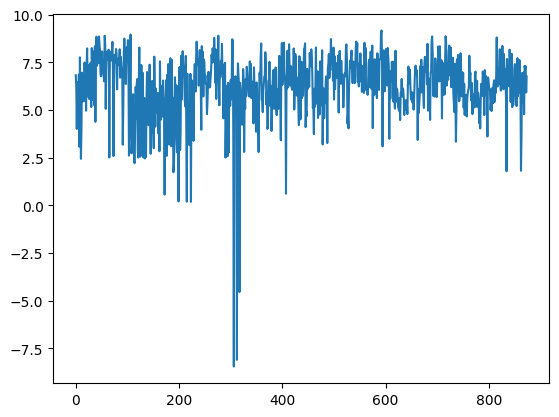

In [118]:
plt.figure()
#plt.plot(tracks_logits_step[0,0,702,:].cpu())

#plt.figure()
plt.plot(visible_logits_step.squeeze().squeeze().cpu())

In [6]:
num_frames = video_tensor_resized.shape[1]
output = {}

for track_id, trajectory in tqdm(track_histories.items()):
    coords = []
    for t in range(num_frames):
        step = next((pos for (frame, pos) in trajectory if frame == t), None)
        coords.append(step if step is not None else torch.tensor([float('nan'), float('nan')]))
    output[track_id] = torch.stack(coords)  # shape: [num_frames, 2]

output_list = [trajectory.unsqueeze(0) for _, trajectory in output.items()]
output_tensor = torch.cat(output_list, dim=0).unsqueeze(0).permute(0,2,1,3)  # shape: [1 , num_frames, num_feats, 2]

output_tensor = output_tensor[:,:,:,[1,0]]
output_tensor[:, : ,:,  :] *= torch.tensor([video[0].shape[1] / model_video_size[0], video[0].shape[0] / model_video_size[1]])

frame_cut_out = output_tensor.shape[1]
frame_cut_out = 120

# Calculate the number of visible frames for each track
visible_counts = torch.sum(~torch.isnan(output_tensor[0, :frame_cut_out, :, 0]), dim=0)

# Filter tracks that are visible for at least 20 frames
visible_tracks_mask = visible_counts >= 1
output_tensor_filtered = output_tensor[:, :frame_cut_out, visible_tracks_mask, :]
output_tensor_filtered.shape

torch.cuda.empty_cache()

100%|██████████| 3649/3649 [00:04<00:00, 784.55it/s]


In [7]:
generate_frame_image_cv(video_tensor_original, output_tensor)

100%|██████████| 223/223 [01:10<00:00,  3.16it/s]


Percentage of missing values: 35.85%


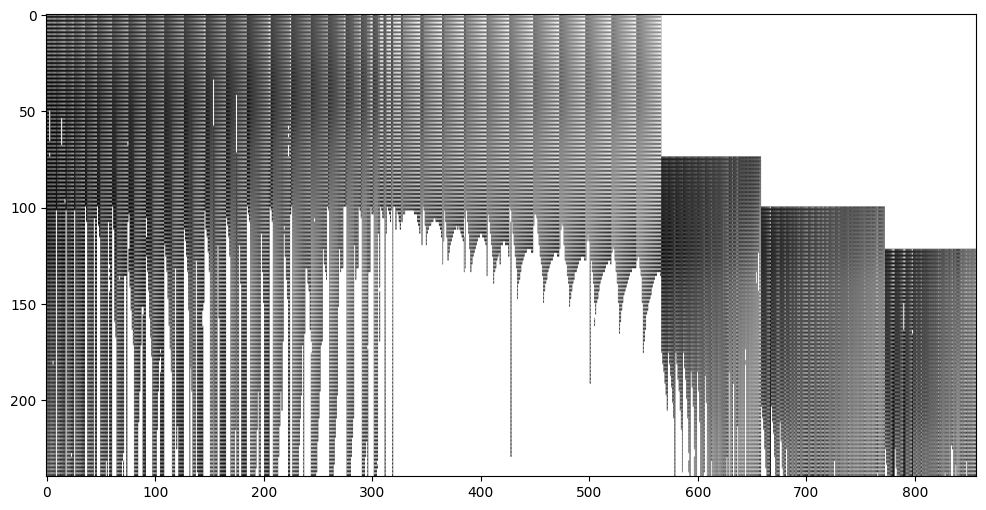

In [38]:
# Reshape the output_tensor to create the observation matrix
# Shape of output_tensor: [1, num_frames, num_feats, 2]
# Desired shape of observation_matrix: [feats*2, frames]

# todo: comparar halucinacao cotracker

obs_mat_full = np.zeros((output_tensor_filtered.shape[1] * 2, output_tensor_filtered.shape[2]), dtype=np.float32)
num_frames = output_tensor_filtered.shape[1]

for frame in range(output_tensor_filtered.shape[1]): # por frame
    obs_mat_full[frame*2, :] = output_tensor_filtered[0, frame, :, 0].cpu().numpy()  # x-coordinates
    obs_mat_full[frame*2+1, :] = output_tensor_filtered[0, frame, :, 1].cpu().numpy()  # y-coordinates

#remove columns (features) that have nan values
obs_mat = obs_mat_full[:, ~np.isnan(obs_mat_full).any(axis=0)]

# remove collumns that have more than 50% nan values
obs_mat_half_missed = obs_mat_full[:, np.sum(np.isnan(obs_mat_full), axis=0) < obs_mat_full.shape[0] / 1.7]

#print the percentage of missing values
missing_percentage = np.sum(np.isnan(obs_mat_half_missed)) / (obs_mat_half_missed.shape[0] * obs_mat_half_missed.shape[1]) * 100
print(f"Percentage of missing values: {missing_percentage:.2f}%")


plt.figure(figsize=(12, 6))
plt.imshow(obs_mat_half_missed/np.nanmax(obs_mat_half_missed), aspect='auto', cmap='gray')
#plt.imshow(obs_mat_full, aspect='auto', cmap='gray', alpha=0.5)


In [ ]:
plt.plot(np.log10(
    torch.linalg.svd(torch.tensor(obs_completed_subpart))[1])
    ,"-x")

 54%|█████▎    | 107/200 [00:15<00:13,  7.10it/s, RMSE=9.576595306396]


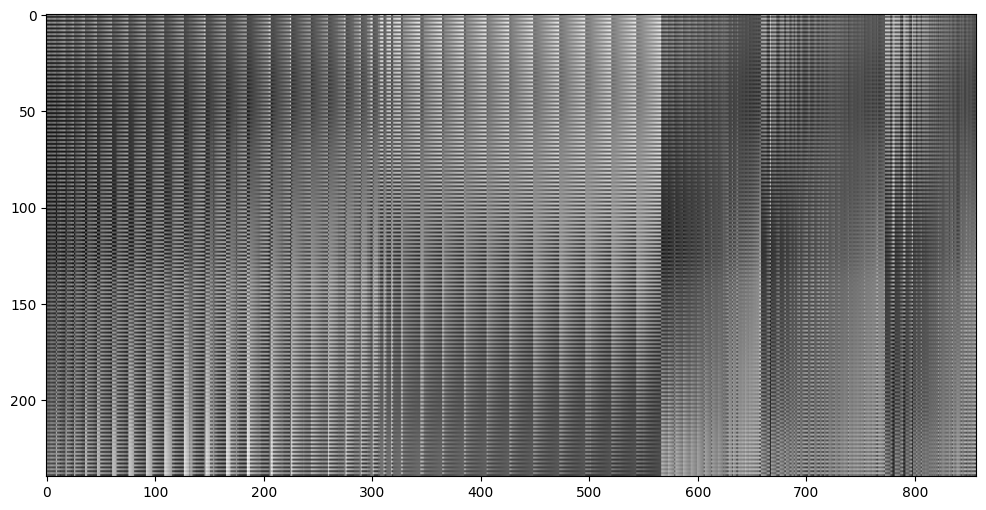

In [13]:
obs_completed, _ = alternating_matrix_completion(obs_mat_half_missed, mode=0, max_iters=200, rank=4)

plt.figure(figsize=(12, 6))
plt.imshow(obs_completed/np.nanmax(obs_completed), aspect='auto', cmap='gray')

#save obs_completed as .mat file
savemat("obs_completed.mat", {"obs_completed": obs_completed})



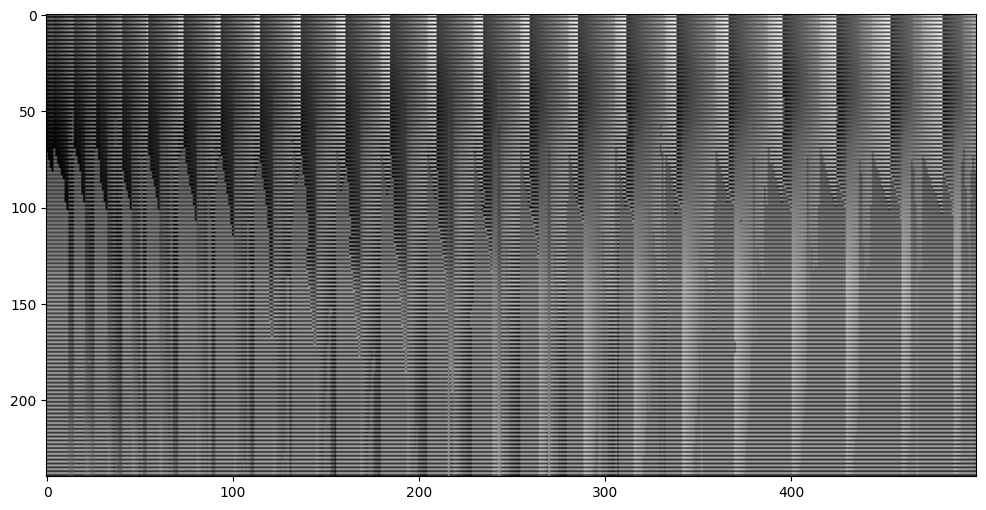

In [46]:
# rank monitoring


def fill_missing_with_row_mean(M_block):
    mask = ~torch.isnan(M_block)
    row_means = torch.nanmean(M_block, dim=1, keepdim=True)
    return torch.where(mask, M_block, row_means)


x_filled = fill_missing_with_row_mean(
    torch.tensor(obs_mat_half_missed[:, :500]).clone()
    )

plt.figure(figsize=(12, 6))
plt.imshow(x_filled/np.nanmax(x_filled), aspect='auto', cmap='gray')


#plt.plot(torch.log10(torch.linalg.svd(x_filled, full_matrices=False).S[:10]),"-x")


In [32]:
# complete just a subpart of the matrix
obs_completed_subpart, _ = alternating_matrix_completion(
    obs_mat_half_missed[:100, :1250], rank=4, mode=0, max_iters=100)


plt.figure(figsize=(12, 6))
plt.imshow(obs_completed_subpart/np.nanmax(obs_completed_subpart), aspect='auto', cmap='gray')

_LinAlgError: linalg.svd: The algorithm failed to converge because the input matrix contained non-finite values.

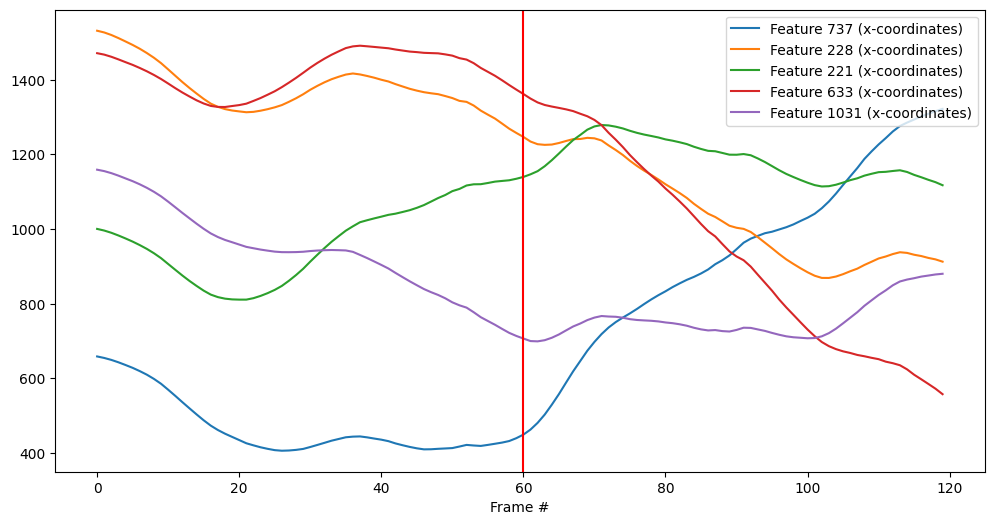

In [24]:
plt.figure(figsize=(12, 6))
selected_indices = np.random.choice(range(150, obs_completed.shape[1]), size=5, replace=False)
for idx in selected_indices:
    plt.plot(obs_completed[::2, idx], label=f"Feature {idx} (x-coordinates)")

# Draw a vertical line at the middle of the plot
plt.axvline(x=obs_completed.shape[0] // 4, color='r')
plt.xlabel("Frame #")
plt.legend()

In [40]:

rr.init("factorization")
rr.notebook_show(width=int(1920*0.75), height=int(1080*0.75))

#rr.log("world/3d_shape", rr.Points3D(marques_factorization(obs_mat)[1].T))

#rr.log("world/3d_completed", rr.Points3D(marques_factorization(obs_completed)[1].T))

#rr.log("world/3d_completed", rr.Points3D(marques_factorization(obs_completed_subpart)[1].T))

rr.log("world/3d_completed", rr.Points3D(shape.T))




# TODO: ADD COLOR TO EACH POINT


Viewer()

In [39]:
# testing costeira marques
from src.factorization import costeira_marques

motion, shape, t = costeira_marques(obs_mat_half_missed)

# it actually works